# RNN model for Sentiment Analysis

## Methods
- display_confusion_matrix
- save_complete_model
- preprocess_data
- create_rnn_model
- train_and_evaluate
- plot_training_history

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, GRU, Dense, BatchNormalization, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from keras.optimizers import *
import time
import os
import datetime
import json
import warnings
warnings.filterwarnings('ignore')

base_path = "/home/subha/aiwork/project"


def display_confusion_matrix(confusion_matrix, 
                             rnn_type,
                           labels=['Negative', 'Positive'],
                           title='Confusion Matrix',
                           figsize=(10, 8),
                           normalize=False,
                           cmap='Blues',
                           save_path=None
                           ):
    """
    Display a confusion matrix with annotations and metrics
    
    Args:
        confusion_matrix: 2x2 numpy array containing confusion matrix values labels: List of labels for classes
        (default: ['Negative', 'Positive'])
        title: Title for the plot (default: 'Confusion Matrix') figsize: Tuple for figure size (default: (10, 8))
        normalize: Whether to normalize values to percentages (default: False) cmap: Color map for the heatmap (default: 'Blues')
        save_path: Path to save the figure (default: None)
        
    Returns:
        matplotlib figure object
    """
    # Create figure and axes
    fig, ax = plt.subplots(figsize=figsize,dpi=300)
    
    # Normalize matrix if requested
    if normalize:
        confusion_matrix = (confusion_matrix.astype('float') / 
                          confusion_matrix.sum(axis=1)[:, np.newaxis])
        fmt = '.2%'
    else:
        fmt = 'd'
    
    # Create heatmap
    sns.heatmap(confusion_matrix, 
                annot=True,            # Show numbers in cells
                fmt=fmt,               # Number format
                cmap=cmap,             # Color scheme
                square=True,           # Square cells
                xticklabels=labels,    # X-axis labels
                yticklabels=labels,    # Y-axis labels
                ax=ax)                 # Axis to plot on
    
    # Calculate metrics
    tn, fp, fn, tp = confusion_matrix.ravel()
    total = tn + fp + fn + tp
    
    # Calculate key metrics
    accuracy = (tp + tn) / total
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
    
    # Add metrics text
    metrics_text = (
        f'Accuracy: {accuracy:.3f}\n'
        f'Precision: {precision:.3f}\n'
        f'Recall: {recall:.3f}\n'
        f'F1 Score: {f1:.3f}'
    )
    
    # Add metrics box
    props = dict(boxstyle='round', facecolor='white', alpha=0.8)
    ax.text(1.5, 0.5, metrics_text,
            transform=ax.transAxes,
            bbox=props,
            fontsize=10,
            verticalalignment='center')
    
    # Customize plot
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    plt.title(title +'-'+ rnn_type)
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()

    #plt.show()
    
    # # Save figure if path provided
    # if save_path:
    #     plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    return fig

def save_complete_model(model, model_type, custom_name=None):
    """
    Save the complete model including architecture, weights, and optimizer state
    
    Args:
        model: Keras model instance
        model_type (str): Type of the model
        custom_name (str, optional): Custom name for the model
        
    Returns:
        str: Path to the saved model
    """
    try:
        epoch_time = str(int(time.time()))
        model_name = f"{custom_name}_{epoch_time}.keras"
        save_path = os.path.join(base_path, "complete_models",custom_name)
        model_path = os.path.join(save_path,model_name)
        
        # Save the complete model
        model.save(model_path)
        
        # Save additional metadata
        metadata = {
            "model_type": model_type,
            "save_date": datetime.datetime.now().isoformat(),
            "keras_version": tf.keras.__version__,
            "model_name": model_name
        }
        
        metadata_path = os.path.join(save_path, f"metadata_{epoch_time}.json")
        with open(metadata_path, 'w') as f:
            json.dump(metadata, f, indent=4)
            
        print(f"Model successfully saved to: {save_path}")
        return save_path
        
    except Exception as e:
        print(f"Error saving complete model: {str(e)}")
        raise

def preprocess_data(texts, labels, tokenizer=None, max_words=5000, max_len=100):
    """
    Preprocess text data for RNN input
    """
    # Tokenize texts
    if tokenizer is None:
        tokenizer = Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(texts)
    
    # Convert texts to sequences
    sequences = tokenizer.texts_to_sequences(texts)
    
    # Pad sequences
    padded_sequences = pad_sequences(sequences, maxlen=max_len)
    
    return padded_sequences, tokenizer


def create_rnn_model(rnn_type, max_words=5000, max_len=100, embedding_dim=100):
    """
    Create RNN model based on specified type
    """
    print("=======================================================================================")
    print("I am in create_rnn_model")
    print("=======================================================================================")

    model = Sequential(name=rnn_type)
    model.add(Embedding(max_words, embedding_dim))
    
    # adding a LSTM layer 
    if rnn_type == 'simple':
        model.add(SimpleRNN(32, activation='relu'))
    elif rnn_type == 'lstm':## Add with attention
        model.add(LSTM(32, return_sequences=False))
    elif rnn_type == 'bilstm':
        # Add Bidirectional LSTM with attention
        model.add(Bidirectional(LSTM(32, return_sequences=True)))
        # Attention mechanism
        model.add(Attention())
    else :
        model.add(GRU(32))
    BatchNormalization()
    model.add(Dropout(0.2))
    
    #adding a dense layer with activation function of relu
    model.add(Dense(16, activation='relu'))
    BatchNormalization()
    model.add(Dropout(0.6))
    
    # adding the final output activation with activation function of softmax
    model.add(Dense(1, activation='sigmoid'))

    optimizer = Adam(learning_rate=0.001)
    
    model.compile(optimizer=optimizer,
                 loss='binary_crossentropy',
                 metrics=['accuracy'])
    #model.summary()
    
    return model

def train_and_evaluate(model, X_train, y_train, X_val, y_val, X_test, y_test, rnn_type, epochs=30):
    """
    Train model and evaluate performance
    """

    print("=======================================================================================")
    print("I am in train_and_evaluate")
    print("=======================================================================================")
    # Early stopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', 
                                 patience=3,
                                 restore_best_weights=True)
    
    # Train model

    history = model.fit(X_train, 
                        y_train,
                        #batch_size=32,
                       epochs=epochs,
                       verbose=1,
                       validation_data=(X_val, y_val)
                       )
    #,
    #callbacks=[early_stopping]
    
    # Evaluate on test set
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    
    model.summary()
    
    save_path = save_complete_model(
                        model=model,
                        model_type=rnn_type,
                        custom_name=f"sentiment_analysis_{rnn_type}"
                    )
    print(f"The Model is saved in {save_path}")
    
    # Generate predictions
    y_pred = (model.predict(X_test) > 0.5).astype(int)
    
    return history, test_loss, test_accuracy, y_pred

def plot_training_history(history, model_name):
    """
    Plot training and validation metrics
    """
    print("=======================================================================================")
    print("I am in plot_training_history")
    print("=======================================================================================")
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4),dpi=300)
    
    
    # Plot accuracy
    #ax1.set_ylim(0, 1.5)
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title(f'{model_name} - Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Validation'])
    
    # Plot loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title(f'{model_name} - Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Validation'])
    
    plt.tight_layout()
    return fig

## Compare Models

In [7]:
def compare_models(X_train, y_train, X_val, X_test, y_val, y_test):
    """
    Compare different RNN architectures
    """

    results = {}
    model_types = ['simple', 'lstm', 'gru']
    #model_types = ['bilstm']
    
    for rnn_type in model_types:
        # Create and train model
        model = create_rnn_model(rnn_type)
        history, test_loss, test_accuracy, y_pred = train_and_evaluate(
            model, X_train, y_train, X_val, y_val, X_test, y_test, rnn_type
        )
        
        # Store results
        results[rnn_type] = {
            'history': history,
            'test_loss': test_loss,
            'test_accuracy': test_accuracy,
            'predictions': y_pred,
            'classification_report': classification_report(y_test, y_pred),
            'confusion_matrix': confusion_matrix(y_test, y_pred)
        }

        #display_confusion_matrix(confusion_matrix(y_test, y_pred))
        
        # Plot training history
        #plot_training_history(history, rnn_type.upper())
        
    return results, tokenizer


## Read Sampled Data 

In [3]:
X_test_ = pd.read_parquet('output/cleandata/test_data_sample/', engine='pyarrow' )
X_train_ = pd.read_parquet('output/cleandata/train_data_sample/', engine='pyarrow' )
X_val_ = pd.read_parquet('output/cleandata/val_data_sample/', engine='pyarrow' )

## Tokenize the Datasets

In [4]:
## Train

X_text_train = list(X_train_["cleaned_text"])
y_train = np.array(X_train_['sentiment']).astype("int32")# X_train_[["sentiment"]]
X_train, tokenizer = preprocess_data(X_text_train, y_train)

## Test

X_text_test = list(X_test_["cleaned_text"])
y_test = np.array(X_test_['sentiment']).astype("int32")# X_train_[["sentiment"]]
X_test, tokenizer = preprocess_data(X_text_test, y_test, tokenizer)

## Val

X_text_val = list(X_val_["cleaned_text"])
y_val = np.array(X_val_['sentiment']).astype("int32")# X_train_[["sentiment"]]
X_val, tokenizer = preprocess_data(X_text_val, y_val, tokenizer)


In [5]:
print(X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape)

(22725, 100) (5607, 100) (5607, 100) (22725,) (5607,) (5607,)


In [8]:
results, tokenizer = compare_models(X_train, y_train, X_val, X_test, y_val, y_test)

I am in create_rnn_model
I am in train_and_evaluate
Epoch 1/30


I0000 00:00:1742137307.534750  189046 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9517 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9
I0000 00:00:1742137308.600380  189206 service.cc:148] XLA service 0x7f6c1400b970 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742137308.600435  189206 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 SUPER, Compute Capability 8.9
2025-03-16 11:01:48.622677: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1742137308.718446  189206 cuda_dnn.cc:529] Loaded cuDNN version 90701


 26/711 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6166 - loss: 0.6824  

I0000 00:00:1742137309.271835  189206 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


711/711 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.8671 - loss: 0.4135 - val_accuracy: 0.8283 - val_loss: 0.3483
Epoch 2/30
711/711 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9263 - loss: 0.2154 - val_accuracy: 0.8834 - val_loss: 0.4566
Epoch 3/30
711/711 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9427 - loss: 0.1797 - val_accuracy: 0.8723 - val_loss: 0.5067
Epoch 4/30
711/711 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.9554 - loss: 0.4258 - val_accuracy: 0.8898 - val_loss: 0.4178
Epoch 5/30
711/711 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9513 - loss: 0.1382 - val_accuracy: 0.8698 - val_loss: 0.5061
Epoch 6/30
711/711 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9669 - loss: 0.1014 - val_accuracy: 0.8689 - val_loss: 0.6975
Epoch 7/30
711/711 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9739 - loss: 0.0790 - val_accuracy: 0.8782 - val_loss: 0.8402
Epoch 8/30
711/711 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9763 - loss: 0.0699 - val_accuracy: 0.8627 - val_

Model: "simple"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 100)       │       500,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 32)             │         4,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,514,405 (5.78 MB)

 Trainable params: 504,801 (1.93 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,009,604 (3.85 MB)

Model successfully saved to: /home/subha/aiwork/project/complete_models/sentiment_analysis_simple
The Model is saved in /home/subha/aiwork/project/complete_models/sentiment_analysis_simple
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step   
I am in create_rnn_model
I am in train_and_evaluate
Epoch 1/30
711/711 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.8991 - loss: 0.3427 - val_accuracy: 0.8753 - val_loss: 0.3341
Epoch 2/30
711/711 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.9463 - loss: 0.1632 - val_accuracy: 0.8796 - val_loss: 0.3876
Epoch 3/30
711/711 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.9586 - loss: 0.1261 - val_accuracy: 0.8844 - val_loss: 0.4459
Epoch 4/30
711/711 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.9695 - loss: 0.0918 - val_accuracy: 0.8723 - val_loss: 0.5354
Epoch 5/30
711/711 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.9745 - loss: 0.0753 - val_accuracy: 0.8741 - val_loss: 0.5686
Epoch 6/30
711/711 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.97

Model: "lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 100, 100)       │       500,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 32)             │        17,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,552,709 (5.92 MB)

 Trainable params: 517,569 (1.97 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,035,140 (3.95 MB)

Model successfully saved to: /home/subha/aiwork/project/complete_models/sentiment_analysis_lstm
The Model is saved in /home/subha/aiwork/project/complete_models/sentiment_analysis_lstm
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step  
I am in create_rnn_model
I am in train_and_evaluate
Epoch 1/30
711/711 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.8948 - loss: 0.3543 - val_accuracy: 0.8953 - val_loss: 0.4317
Epoch 2/30
711/711 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.9499 - loss: 0.1609 - val_accuracy: 0.8709 - val_loss: 0.3702
Epoch 3/30
711/711 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.9663 - loss: 0.1160 - val_accuracy: 0.8864 - val_loss: 0.4704
Epoch 4/30
711/711 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.9760 - loss: 0.0898 - val_accuracy: 0.8752 - val_loss: 0.5696
Epoch 5/30
711/711 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.9792 - loss: 0.0760 - val_accuracy: 0.8746 - val_loss: 0.6844
Epoch 6/30
711/711 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.9821 - 

Model: "gru"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 100, 100)       │       500,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 32)             │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,540,229 (5.88 MB)

 Trainable params: 513,409 (1.96 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,026,820 (3.92 MB)

Model successfully saved to: /home/subha/aiwork/project/complete_models/sentiment_analysis_gru
The Model is saved in /home/subha/aiwork/project/complete_models/sentiment_analysis_gru
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step 


## Evaluation

### Accuracy & Loss (Simple)

I am in plot_training_history


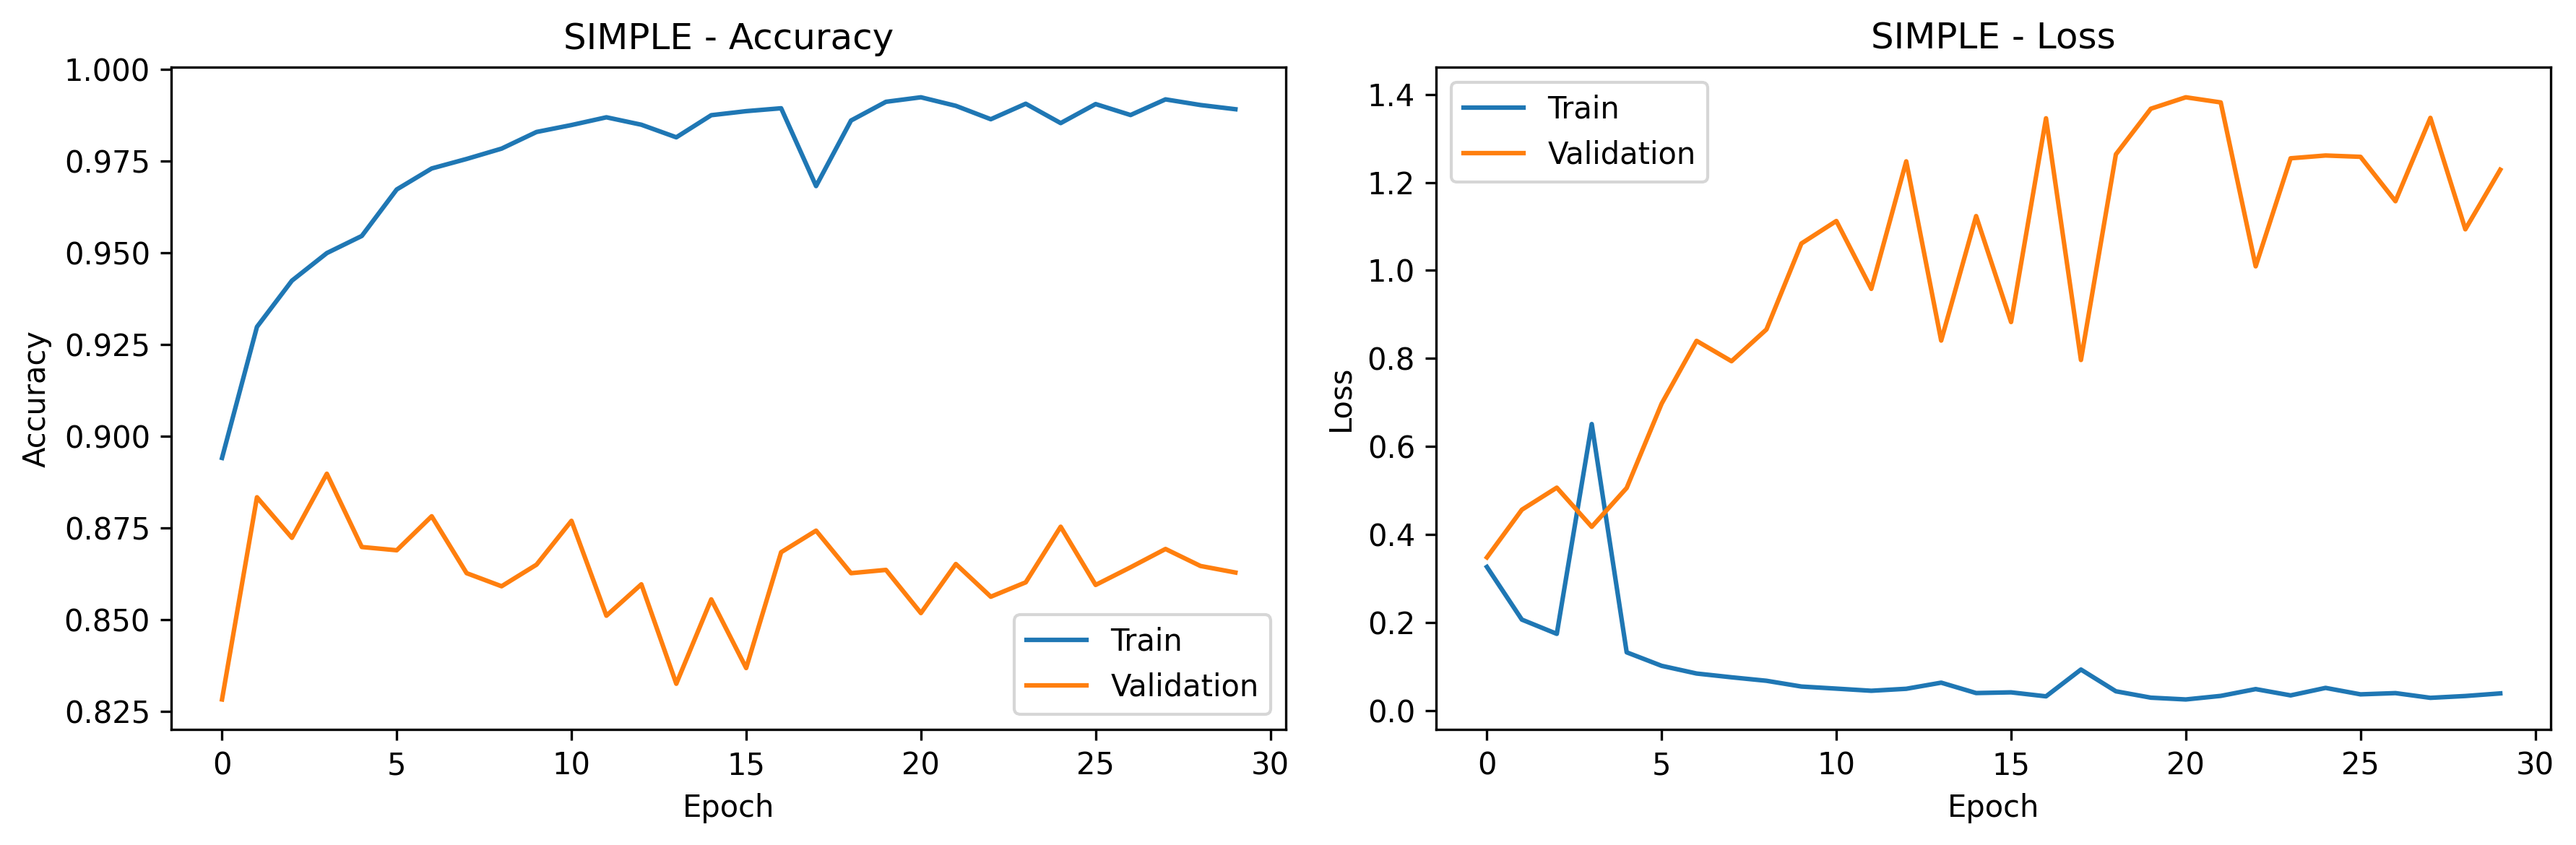

In [9]:
model_types = ['simple', 'lstm', 'gru']
plot_training_history(results[model_types[0]]["history"], model_types[0].upper()).show()

### Confusion Matrix (Simple)

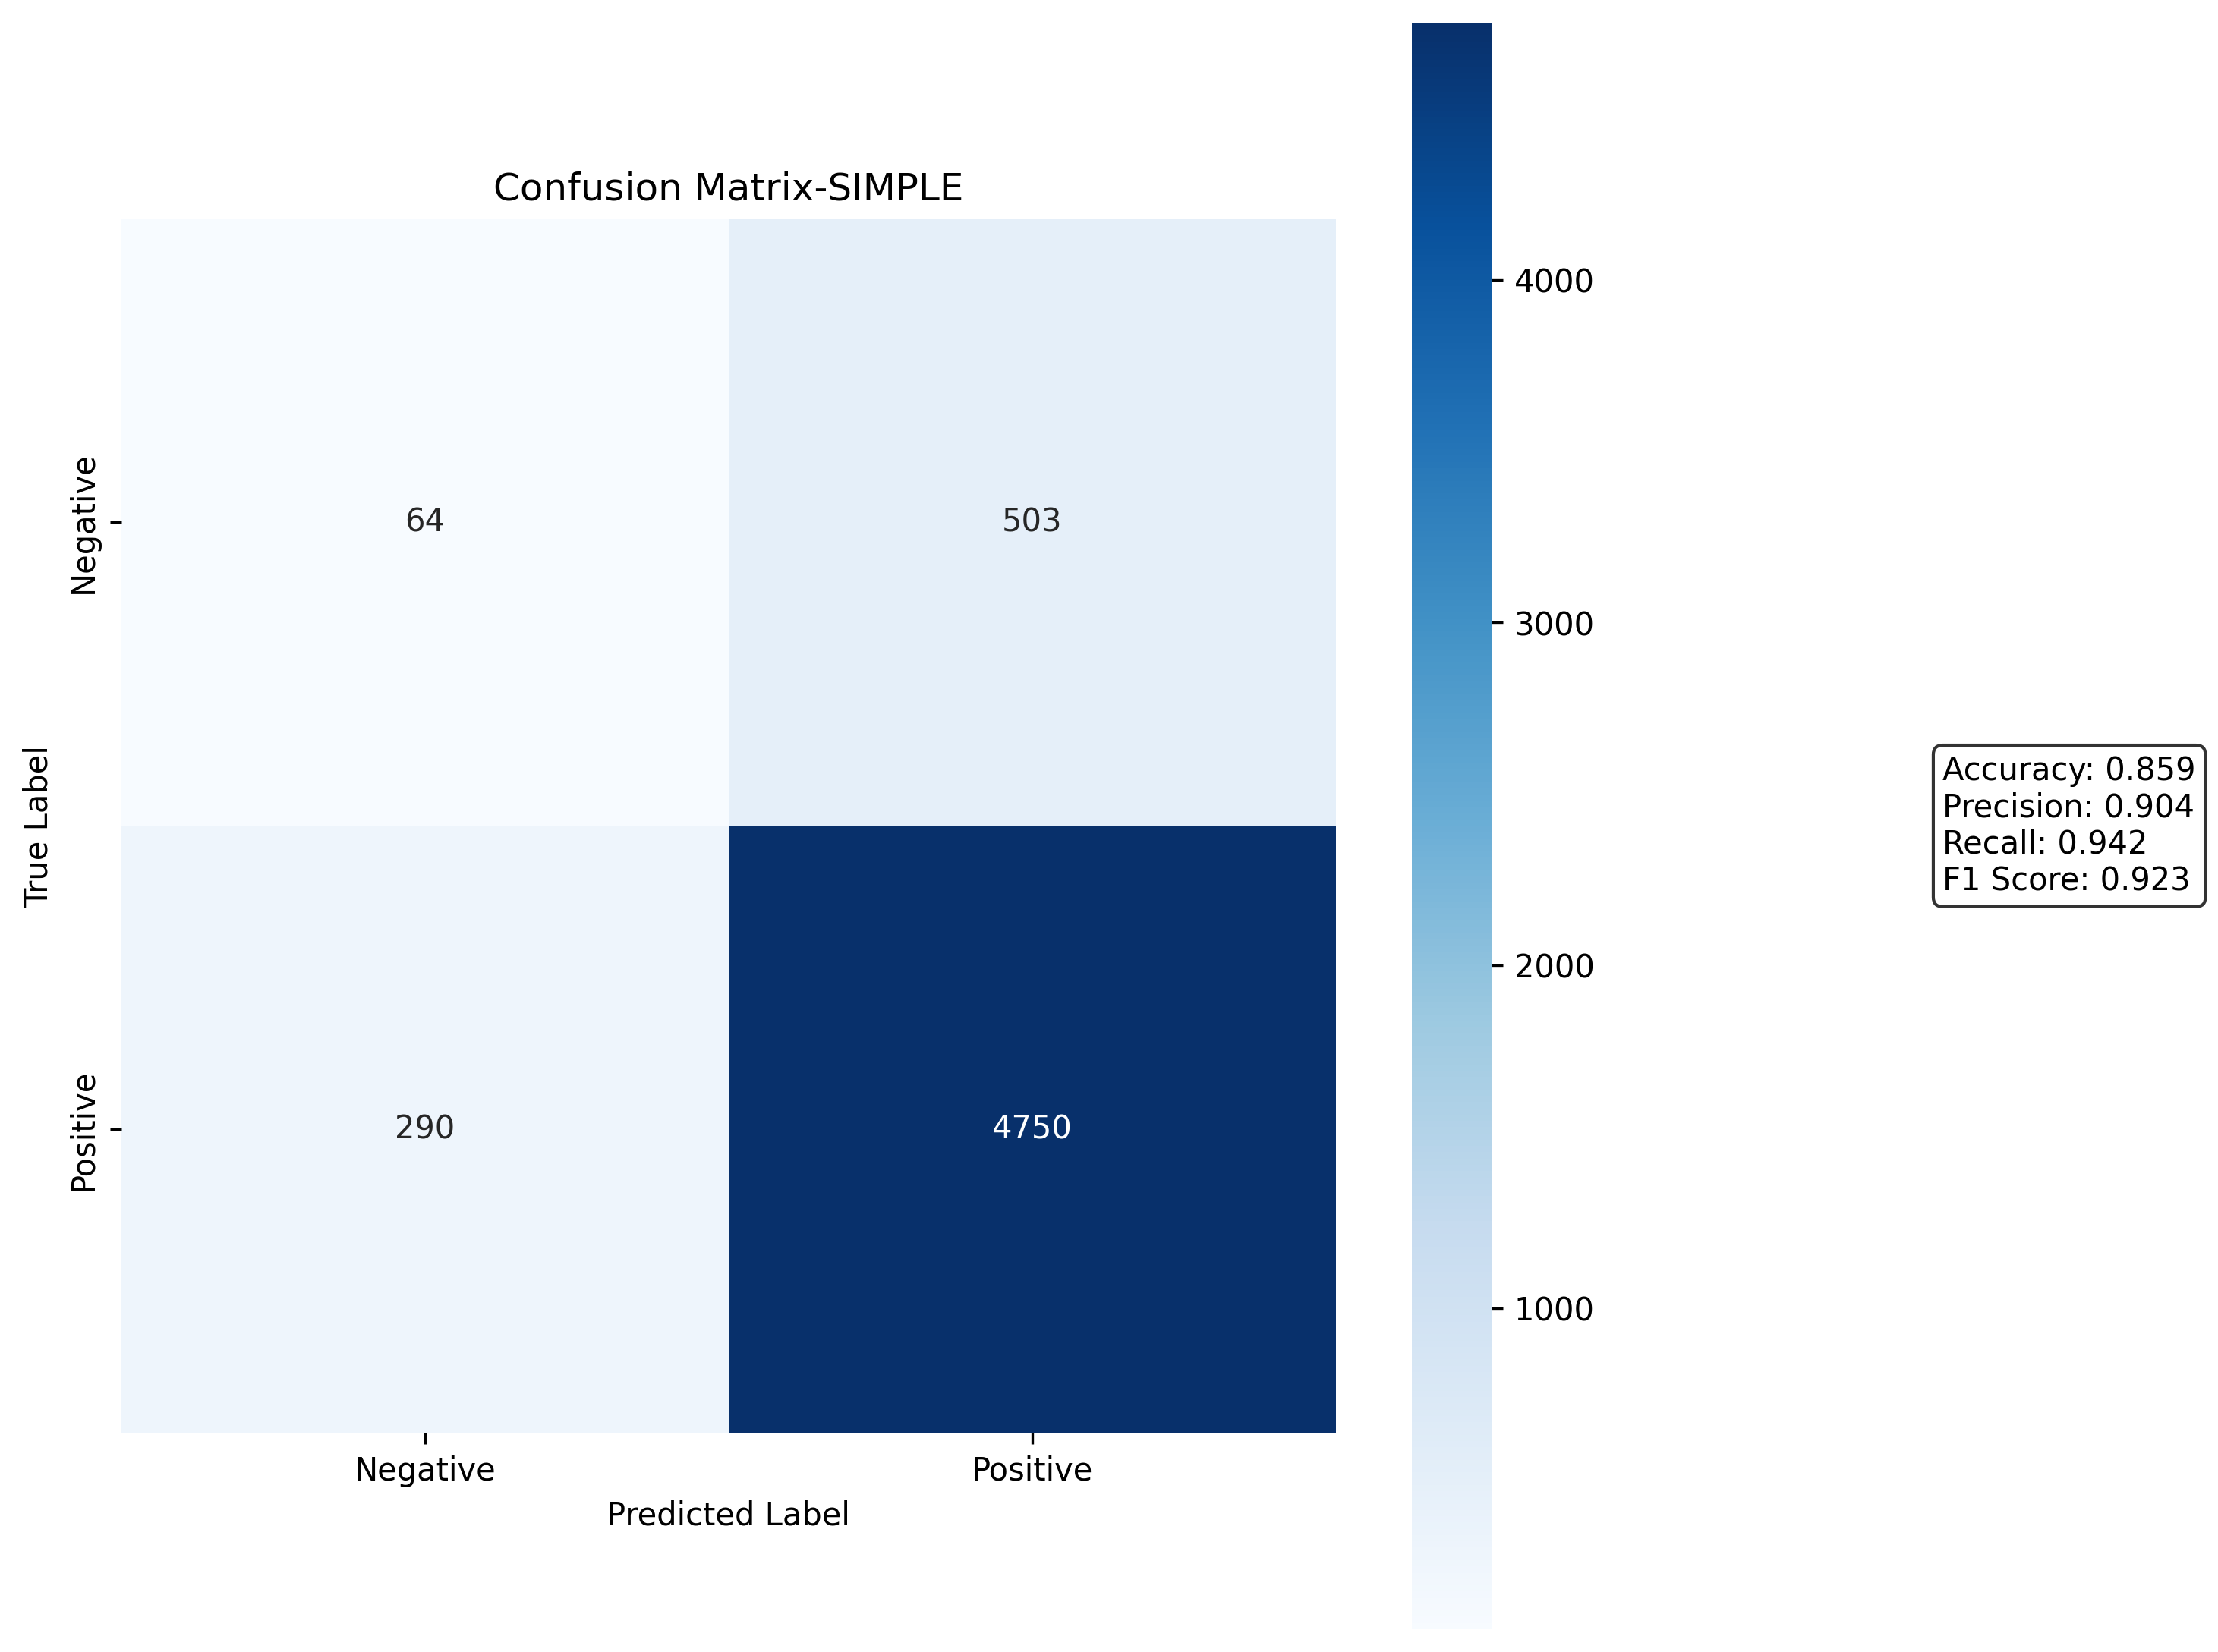

In [10]:
display_confusion_matrix(results[model_types[0]]["confusion_matrix"],model_types[0].upper()).show()

### Accuracy & Loss (LSTM)

I am in plot_training_history


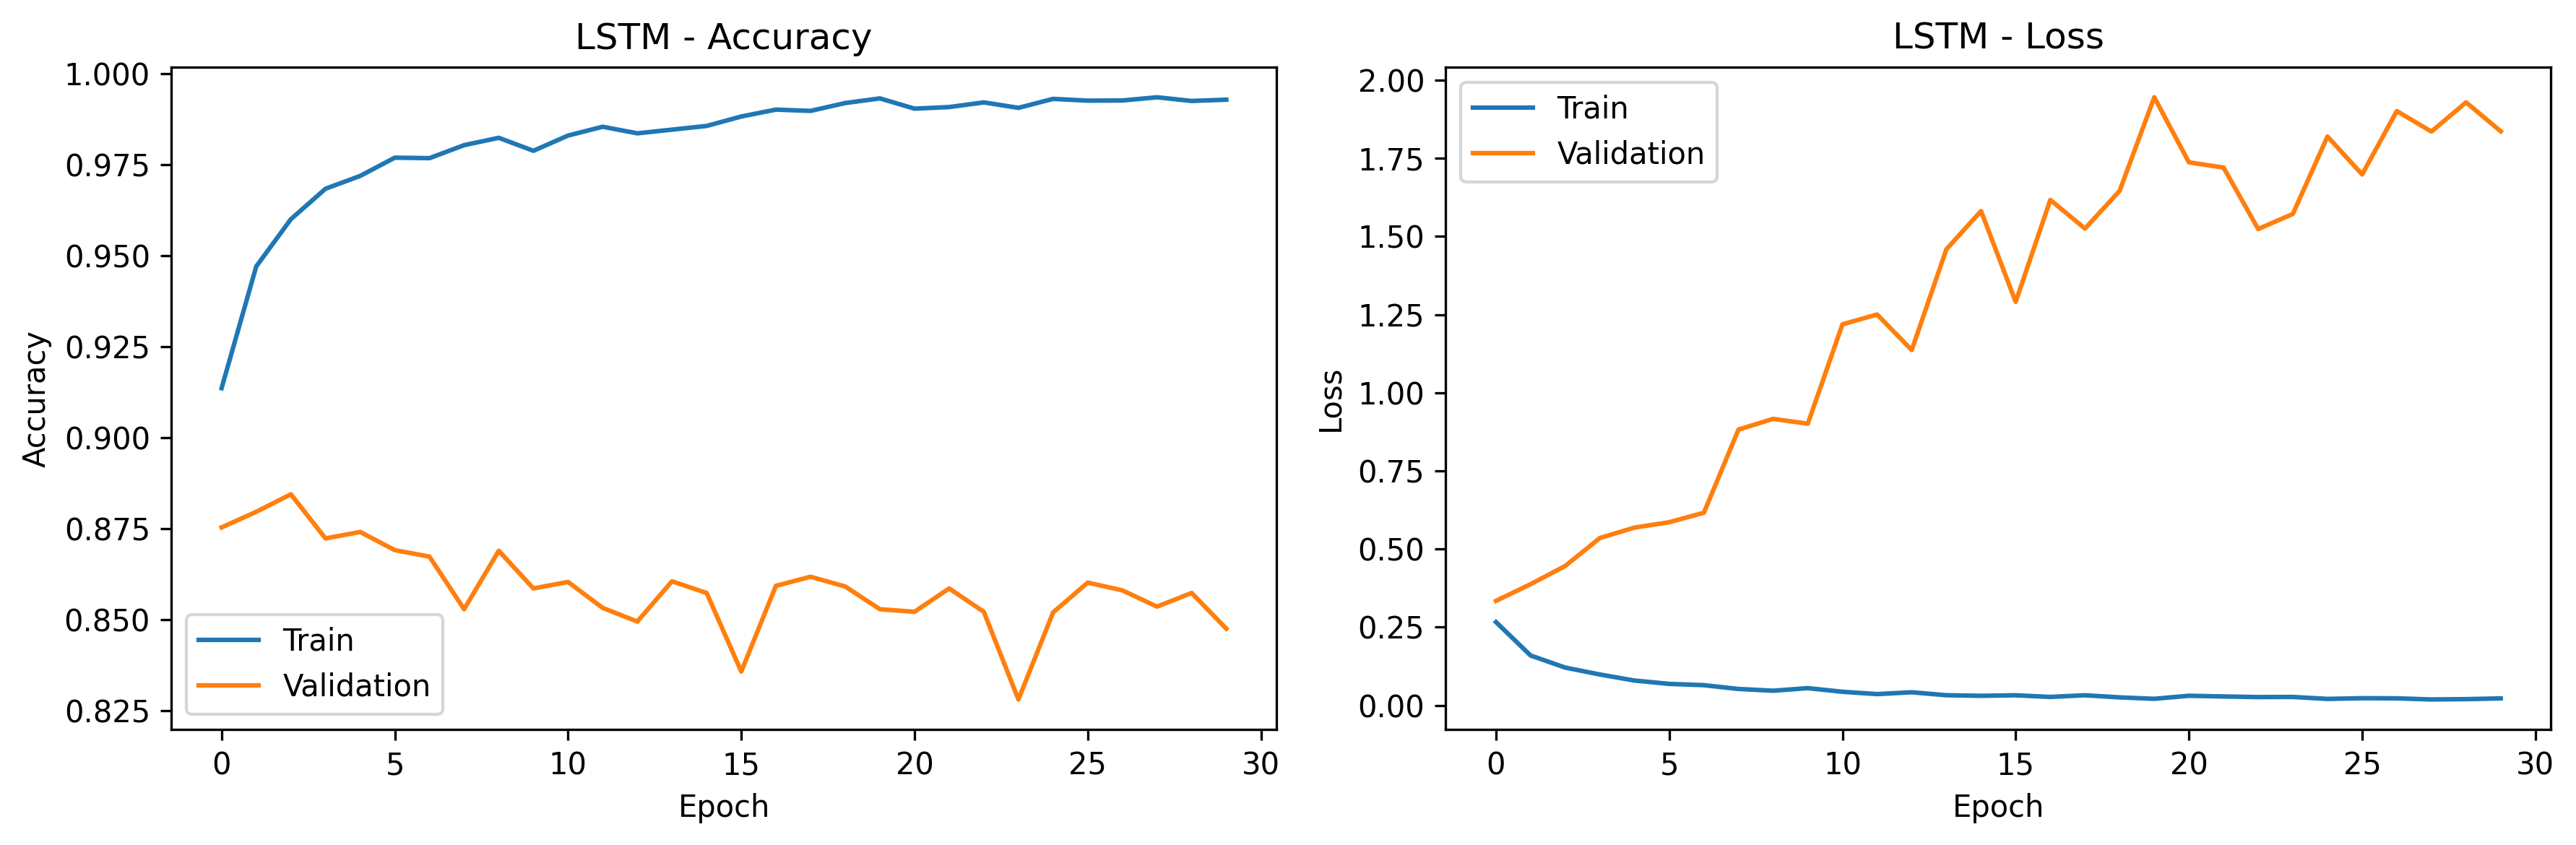

In [11]:
model_types = ['simple', 'lstm', 'gru']
plot_training_history(results[model_types[1]]["history"], model_types[1].upper()).show()

### Confusion Matrix(LSTM)

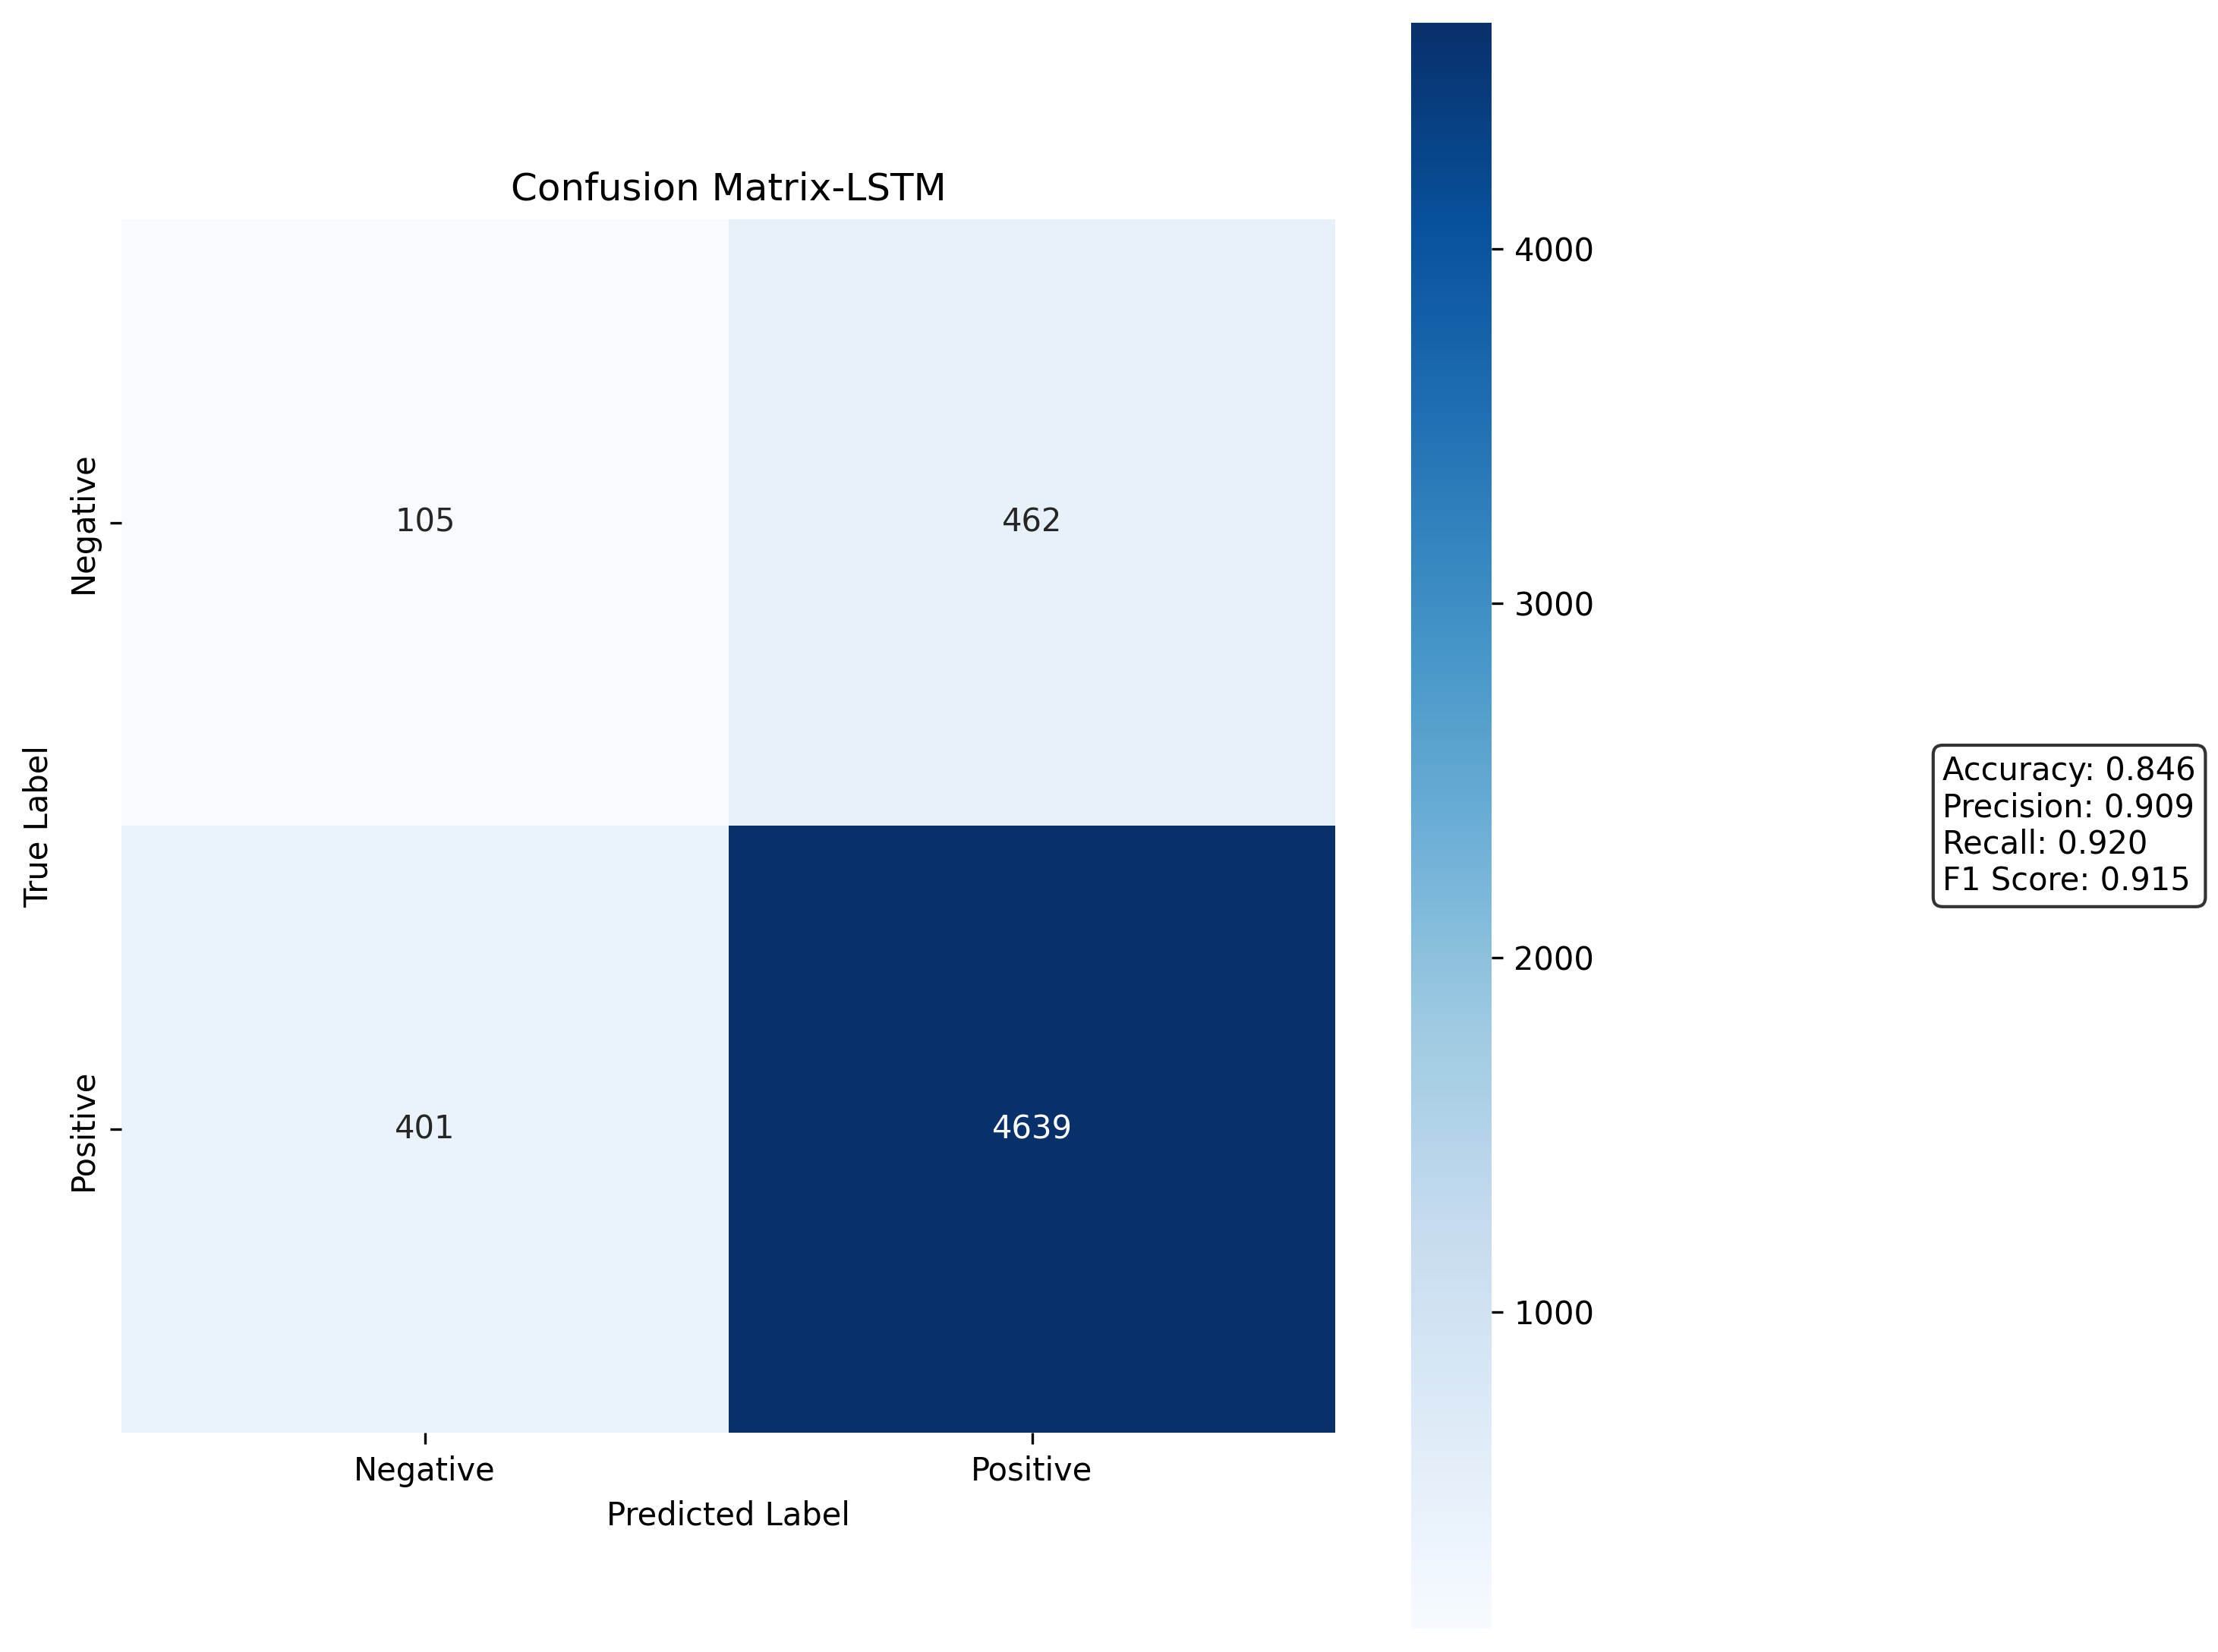

In [12]:
display_confusion_matrix(results[model_types[1]]["confusion_matrix"],model_types[1].upper()).show()

### Accuracy & Loss (GRU)

I am in plot_training_history


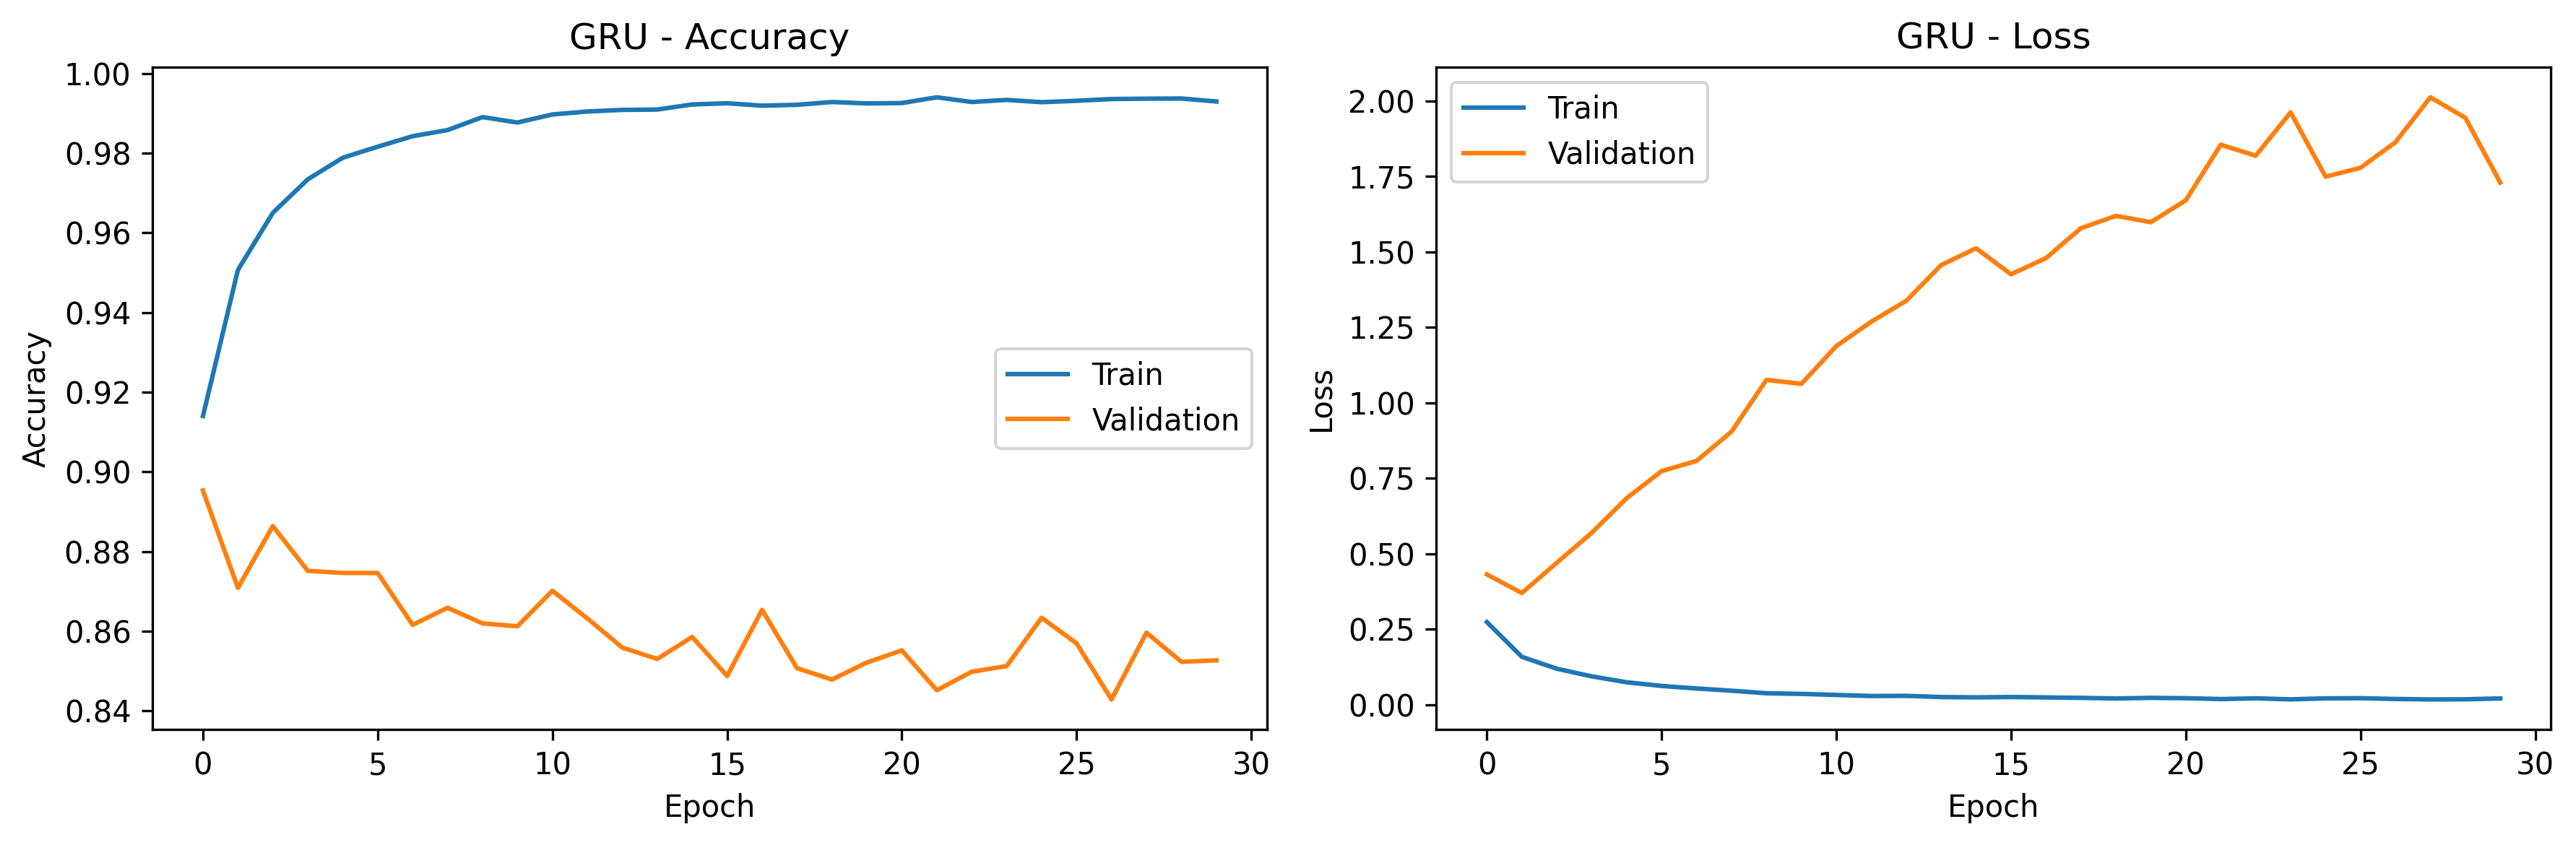

In [13]:
model_types = ['simple', 'lstm', 'gru']
plot_training_history(results[model_types[2]]["history"], model_types[2].upper()).show()

### Confusion Matrix (LSTM)

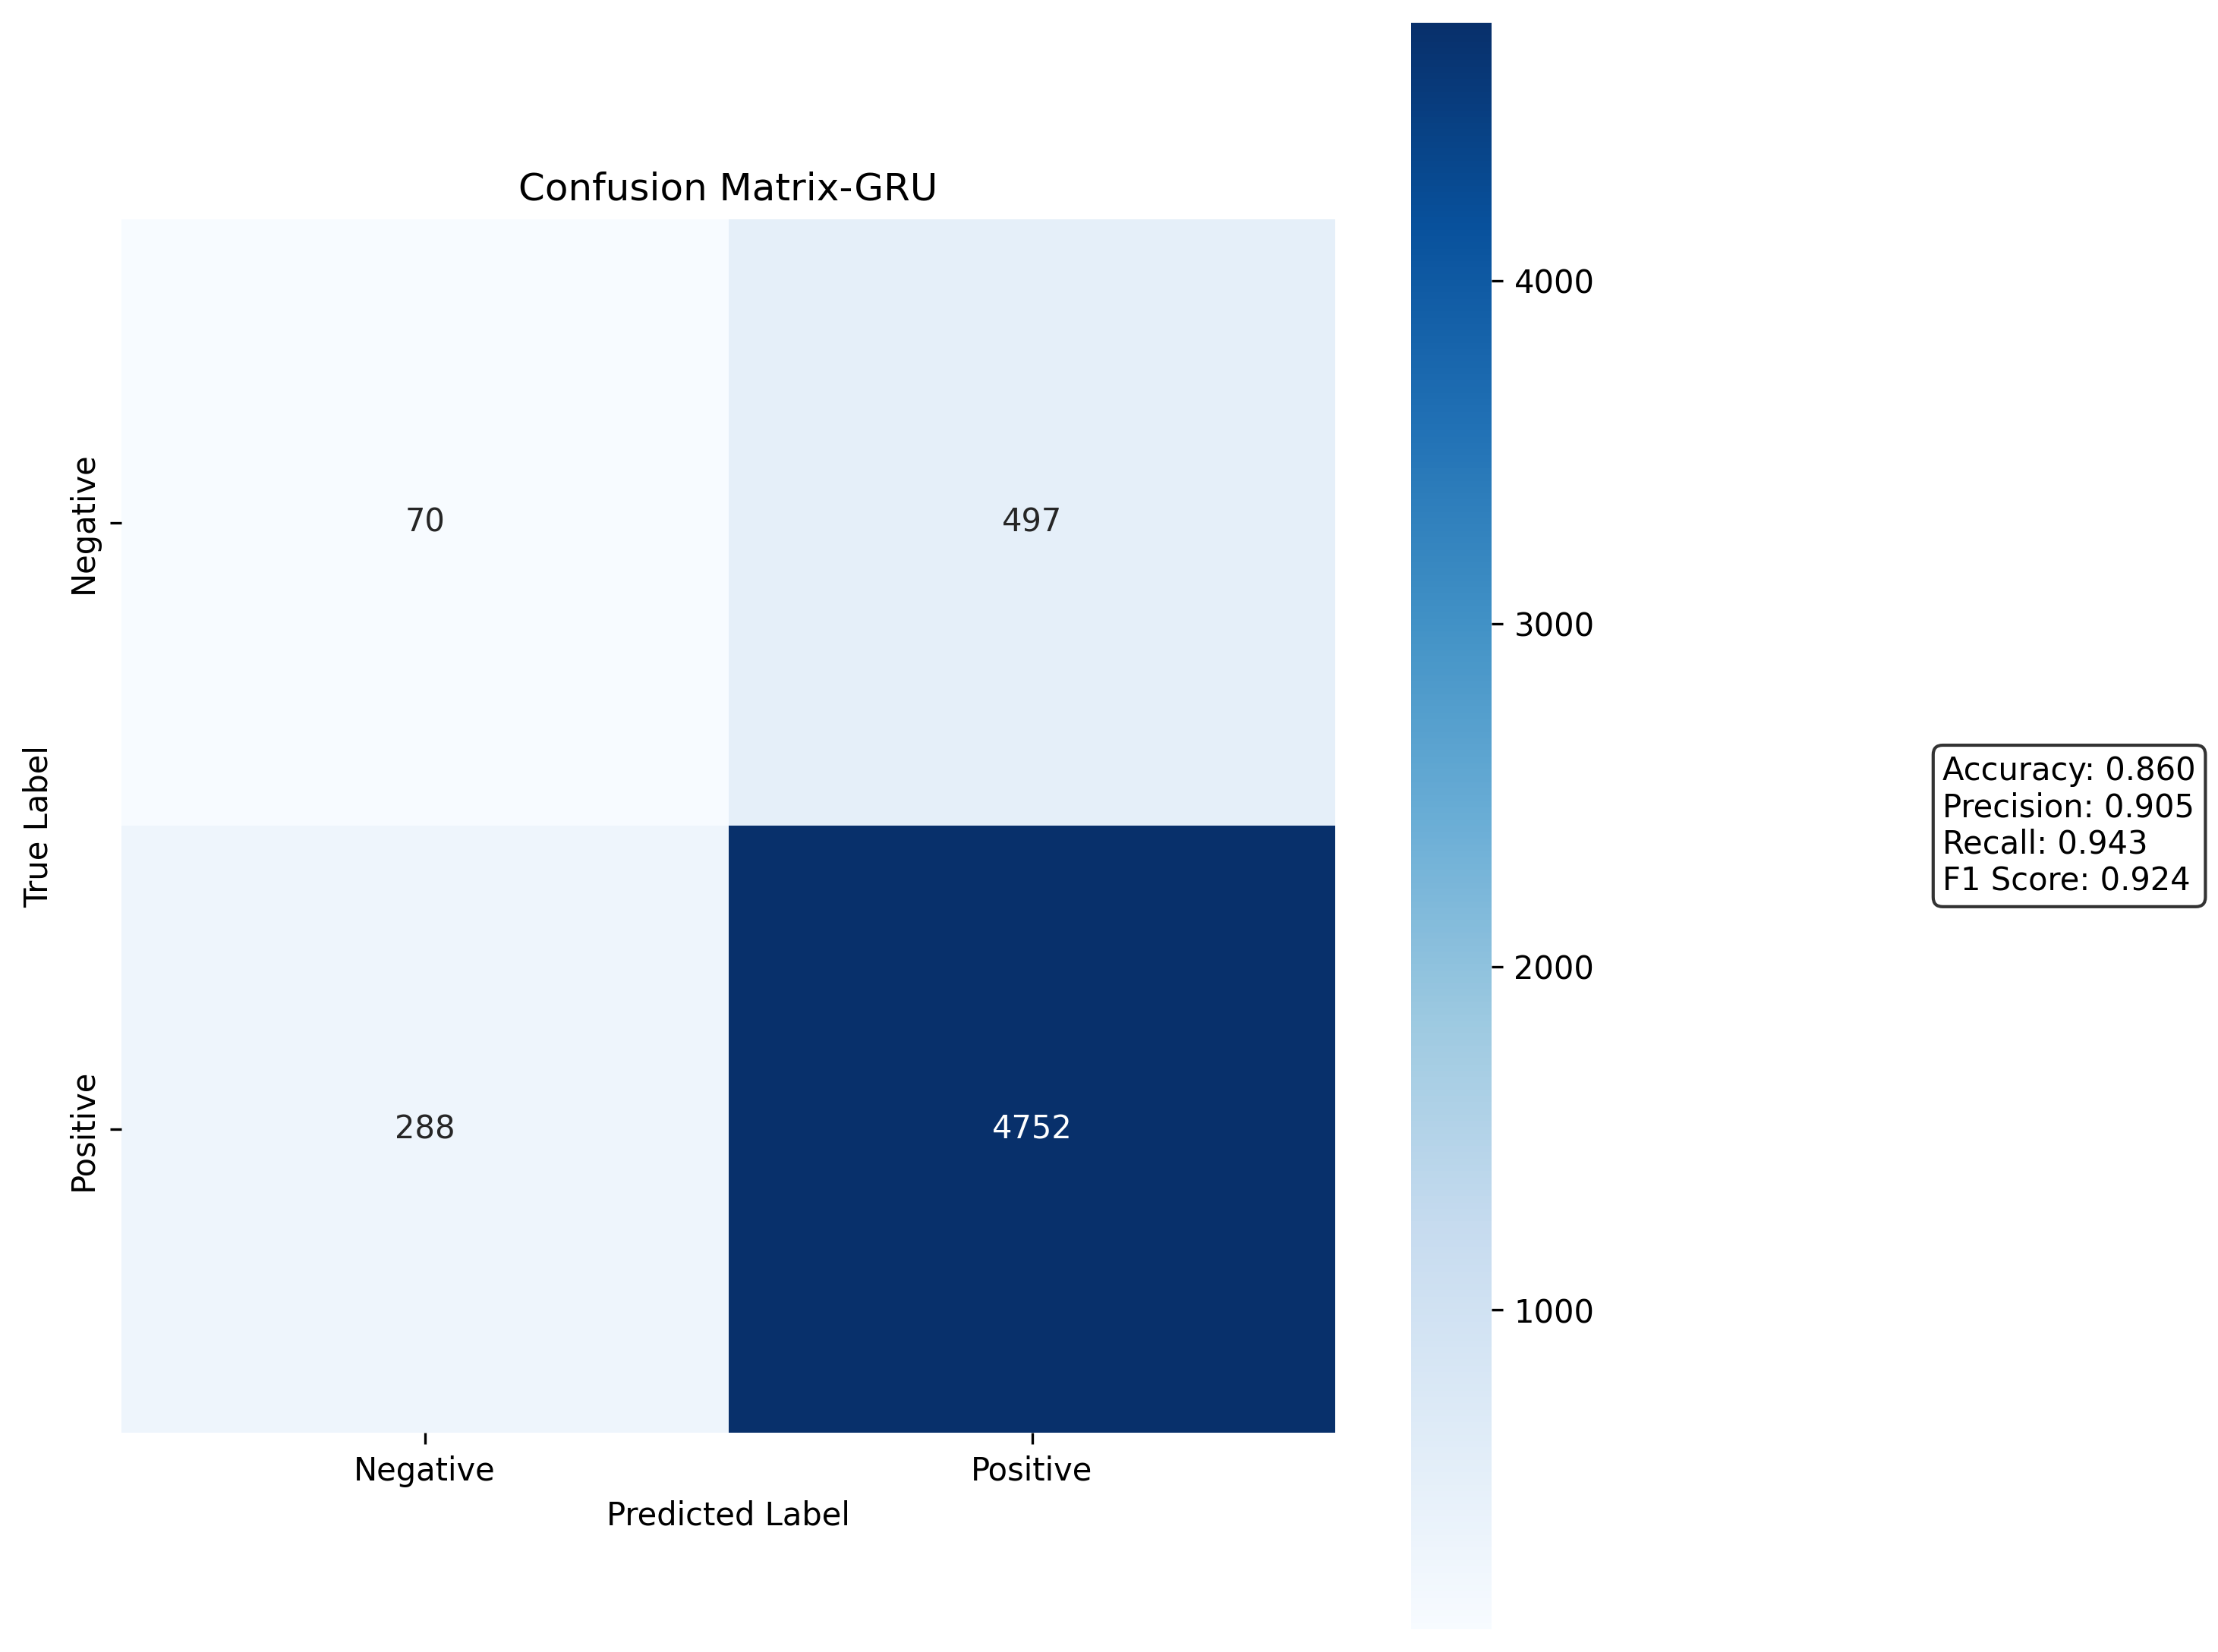

In [14]:
display_confusion_matrix(results[model_types[2]]["confusion_matrix"],model_types[2].upper()).show()

## Appendix

In [42]:
X_test_ = pd.read_parquet('output/cleandata/test_data/', engine='pyarrow' ).head(1111)
X_train_ = pd.read_parquet('output/cleandata/train_data/', engine='pyarrow' ).head(10000)

In [48]:
X_test_ = pd.read_parquet('output/cleandata/test_data/part-00000-011039b5-23dd-403b-adb8-a07a41bccca5-c000.snappy.parquet', engine='pyarrow' )
X_train_ = pd.read_parquet('output/cleandata/train_data/part-00000-607e2d01-50ea-48e9-9d34-7cf60f51a344-c000.snappy.parquet', engine='pyarrow' )

In [43]:
X_text_train = list(X_train_["cleaned_text"])
#y_train = pd.get_dummies(X_train, columns = ['sentiment'])[["sentiment_negative","sentiment_positive"]]
y_train = np.array(X_train_['sentiment']).astype("int32")# X_train_[["sentiment"]]
X_train, tokenizer = preprocess_data(X_text_train, y_train)
    
X_text_temp = list(X_test_["cleaned_text"])
y_temp = np.array(X_test_['sentiment']).astype("int32") #X_test_[["sentiment"]]
#y_temp = pd.get_dummies(X_test, columns = ['sentiment'])[["sentiment_negative","sentiment_positive"]]
X_temp, tokenizer = preprocess_data(X_text_temp, y_temp)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [12]:
X_test_ = pd.read_parquet('output/cleandata/test_data_sample/part-00000-4aa1b099-8015-49cc-8721-01f3aa363fe8-c000.snappy.parquet', engine='pyarrow' )
X_train_ = pd.read_parquet('output/cleandata/train_data_sample/part-00000-f1e283ae-878e-48f5-8e17-306d7e91ac2d-c000.snappy.parquet', engine='pyarrow' )
X_val_ = pd.read_parquet('output/cleandata/val_data_sample/part-00000-7ea62ff1-7ba1-44da-8148-358b1edb9b95-c000.snappy.parquet', engine='pyarrow' )

In [117]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(list(X_train_["cleaned_text"]))

In [118]:
# Convert texts to sequences
sequences = tokenizer.texts_to_sequences(list(X_train_["cleaned_text"]))

In [120]:
# Pad sequences
padded_sequences = pad_sequences(sequences, maxlen=10000)

In [121]:
padded_sequences[2]

array([  0,   0,   0, ..., 117,  69,  28], dtype=int32)

In [122]:
sequences[2]

[539,
 311,
 2,
 351,
 16,
 20,
 4,
 24,
 5,
 939,
 293,
 2818,
 14,
 8,
 25,
 3,
 11,
 5,
 36,
 25,
 28,
 358,
 612,
 6,
 9,
 1282,
 1751,
 2,
 1292,
 2,
 13,
 10,
 887,
 54,
 5,
 9564,
 9,
 3879,
 17,
 1,
 107,
 314,
 15,
 1,
 73,
 373,
 7,
 1,
 18,
 1611,
 28,
 895,
 490,
 226,
 95,
 518,
 1,
 277,
 5,
 1060,
 2669,
 7,
 1,
 664,
 121,
 234,
 6,
 629,
 8,
 50,
 4,
 24,
 47,
 7,
 1675,
 14,
 4670,
 26,
 840,
 2,
 98,
 117,
 69,
 28]

In [3]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2025-02-23 13:45:04.700296: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-23 13:45:04.799680: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740336304.842313  133764 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740336304.856052  133764 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-23 13:45:04.961204: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Num GPUs Available:  1


In [4]:
import gc

In [5]:
obj = None

# Collect garbage
gc.collect()

41

In [6]:
tf.keras.backend.clear_session()

In [67]:
!nvidia-smi

Sun Mar  2 12:33:25 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.86.16              Driver Version: 572.16         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070 ...    On  |   00000000:01:00.0 Off |                  N/A |
|  0%   26C    P8              1W /  220W |   11568MiB /  12282MiB |     14%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [8]:
!nvidia-smi  -L

GPU 0: NVIDIA GeForce RTX 4070 SUPER (UUID: GPU-40292fc1-c848-a256-79c7-1ec1a07d8fa8)


In [9]:
!nvidia-smi  -rmc

The current user does not have permission to change clocks for GPU 00000000:01:00.0.
Terminating early due to previous errors.


In [30]:
X_val[100]

array([   1,   13,   16,    8, 1591, 3411,    2,    7, 2485,   21,   27,
         18,    2,   19,    1, 1434,  291,  312, 1596,    1, 3412,    3,
        377,    1, 3413,   13,   83,   12,    1, 2484,   22,  155,  653,
       1434,    2,  183,   36,   19,    8, 3414, 3415,   21,   75,  363,
         97,  670,  236,   21,  860,  617], dtype=int32)

In [ ]:
# def create_rnn_model(rnn_type, max_words=10000, max_len=100, embedding_dim=1000):
#     """
#     Create RNN model based on specified type
#     """
#     print("=======================================================================================")
#     print("I am in create_rnn_model")
#     print("=======================================================================================")
#     model = Sequential([
#         Embedding(max_words, embedding_dim, input_length=max_len),
#         {
#             'simple': SimpleRNN(64),
#             'lstm': LSTM(64),
#             'gru': GRU(64)
#         }[rnn_type],
#         Dense(32, activation='relu'),
#         Dense(1, activation='sigmoid')
#     ])

#     optimizer = Adam(learning_rate=0.0001)
    
#     model.compile(optimizer=optimizer,
#                  loss='binary_crossentropy',
#                  metrics=['accuracy'])
#     model.summary()
    
#     return model
